# Bayesian/Frequentist Tutorial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Ignore some future deprecation warnings to clean up outputs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

In this notebook we demo how to perform the same set of analyses using a frequentist approach and a bayesian approach.  
We'll perform two sets of analyses:  
1) Simple between groups t-test (i.e. univariate regression with dummy-coding)   
2) Multi-level multivariate regression model (with 1 predictor, random intercepts + slopes)  
We'll estimate the frequentist statistics using [statsmodels](http://www.statsmodels.org/stable/mixed_linear.html)  
Alternatively we can use [pymer4](http://eshinjolly.com/pymer4/) which fully supports all multi-level models estimable by [lme4](https://cran.r-project.org/web/packages/lme4/index.html) 

## Generate t-test data

In [3]:
a = np.random.normal(5,2,1000)
b = np.random.normal(8,2.5,1000)
df = pd.DataFrame({'Group':['a']*1000 + ['b']*1000,'Val':np.hstack([a,b])})

In [4]:
df.groupby('Group').describe()

Val                                                              \
        count      mean       std       min       25%       50%       75%   
Group                                                                       
a      1000.0  5.099432  2.090932 -1.774193  3.675614  5.069739  6.480828   
b      1000.0  8.011600  2.394136 -0.731252  6.335610  7.943481  9.544192   

                  
             max  
Group             
a      12.190856  
b      15.751143

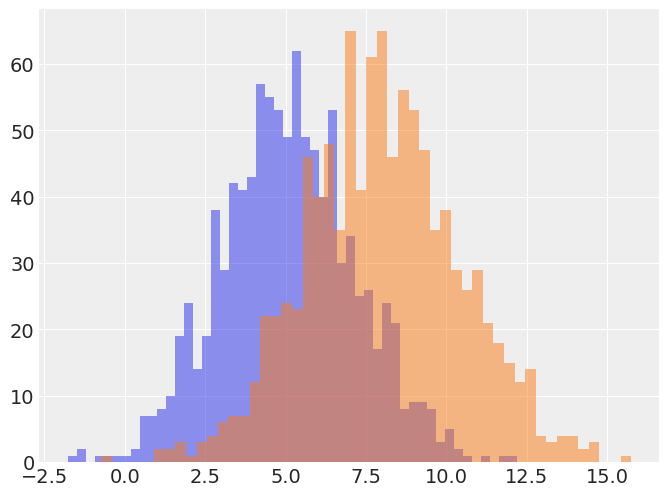

In [5]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(a,alpha=.5,bins=50);
ax.hist(b,alpha=.5,bins=50);

### Frequentist  
Since this analysis is relateively straightforward we can perform a between groups t-test using scipy

In [6]:
from scipy.stats import ttest_ind
ttest_ind(b,a)

Ttest_indResult(statistic=28.971583411911016, pvalue=2.2389404736996383e-154)

We can also set this up as a dummy-coded univariate regression model which is identical

In [7]:
# Using statsmodels, but we could have used pymer4 instead
import statsmodels.formula.api as smf

# The C() syntax tells the patsy library (which parses statsmodels formulae) to treat
# Group as a categorical variable
result = smf.ols('Val ~ C(Group)', df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    Val   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     839.4
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          2.24e-154
Time:                        19:34:34   Log-Likelihood:                -4456.6
No. Observations:                2000   AIC:                             8917.
Df Residuals:                    1998   BIC:                             8929.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0994      0.071     71.745

### Bayesian
We can compute the equivalent dummy-coded regression model to estimate with bambi and the pymc3 backend

In [8]:
from bambi import Model
import pymc3 as pm
import bambi

b_model = Model(df)
res_b = b_model.fit('Val ~ Group',samples=1000,chains=3)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Val_sd, Group, Intercept]
INFO:pymc3:NUTS: [Val_sd, Group, Intercept]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:03<00:00, 1200.49draws/s]
The acceptance probability does not match the target. It is 0.8812196241853603, but should be close to 0.8. Try to increase the number of tuning steps.


In [9]:
# Here's the setup for the model
b_model.backend.model

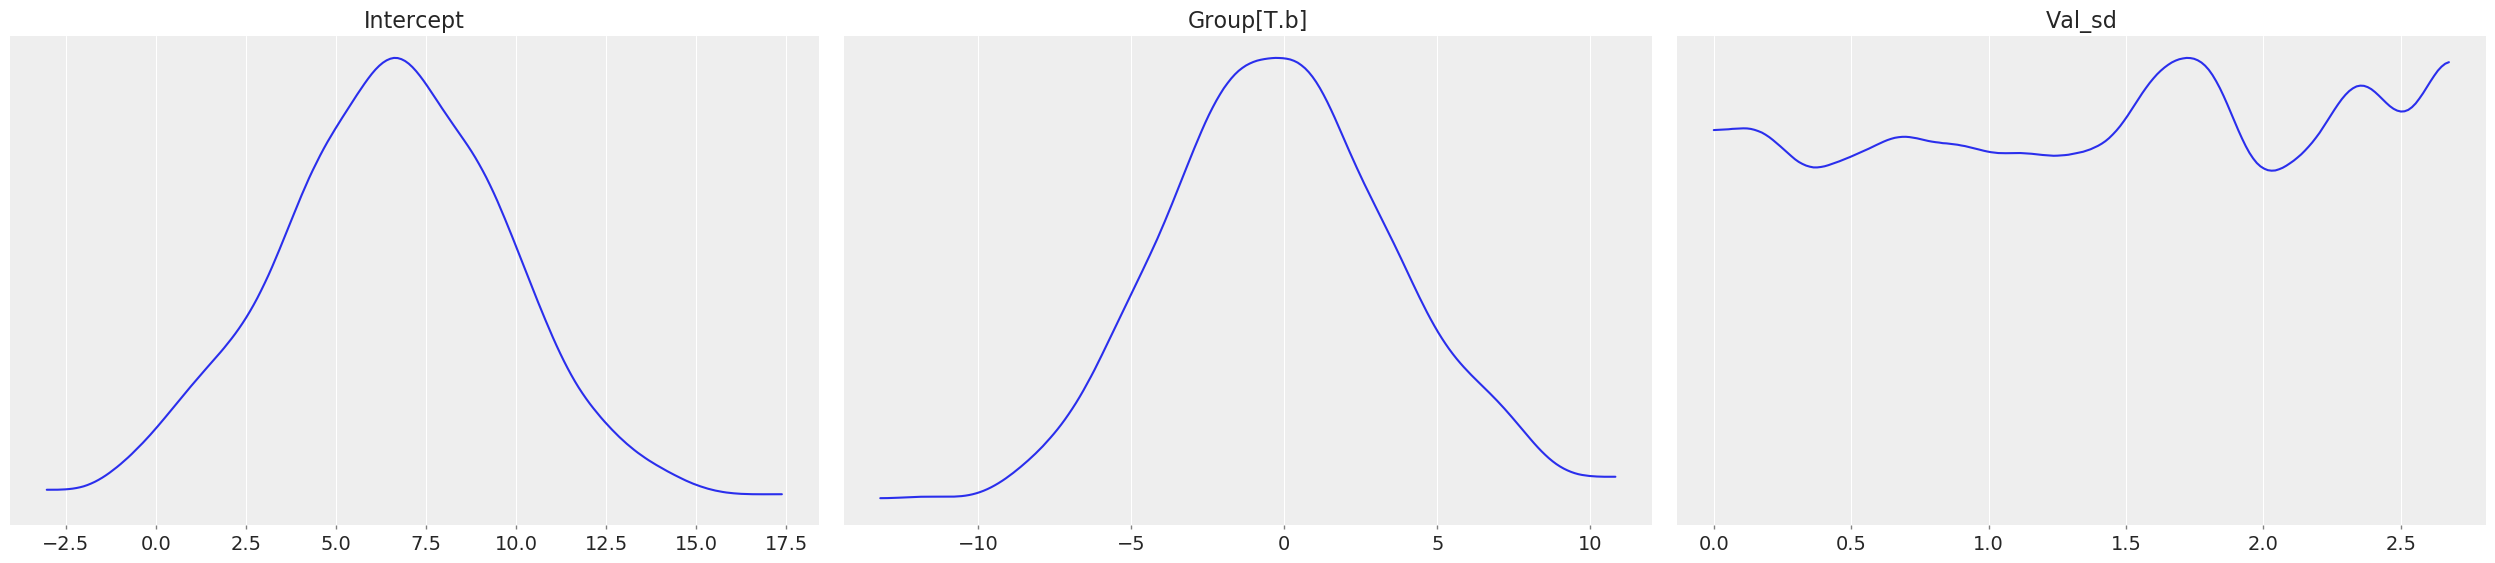

In [10]:
# Model priors
b_model.plot();

In [11]:
res_b.posterior

<xarray.Dataset>
Dimensions:          (Group_dim_0: 1, Intercept_dim_0: 1, chain: 3, draw: 1000)
Coordinates:
  * chain            (chain) int64 0 1 2
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Intercept_dim_0  (Intercept_dim_0) int64 0
  * Group_dim_0      (Group_dim_0) int64 0
Data variables:
    Intercept        (chain, draw, Intercept_dim_0) float64 5.023 ... 4.965
    Group            (chain, draw, Group_dim_0) float64 2.897 3.045 ... 3.019
    Val_sd           (chain, draw) float64 2.279 2.251 2.231 ... 2.239 2.285
Attributes:
    created_at:                 2019-11-17T22:34:47.700572
    inference_library:          pymc3
    inference_library_version:  3.7

In [12]:
res_b.posterior.sel(draw=slice(100, -1))

<xarray.Dataset>
Dimensions:          (Group_dim_0: 1, Intercept_dim_0: 1, chain: 3, draw: 0)
Coordinates:
  * chain            (chain) int64 0 1 2
  * draw             (draw) int64 
  * Intercept_dim_0  (Intercept_dim_0) int64 0
  * Group_dim_0      (Group_dim_0) int64 0
Data variables:
    Intercept        (chain, draw, Intercept_dim_0) float64 
    Group            (chain, draw, Group_dim_0) float64 
    Val_sd           (chain, draw) float64 
Attributes:
    created_at:                 2019-11-17T22:34:47.700572
    inference_library:          pymc3
    inference_library_version:  3.7

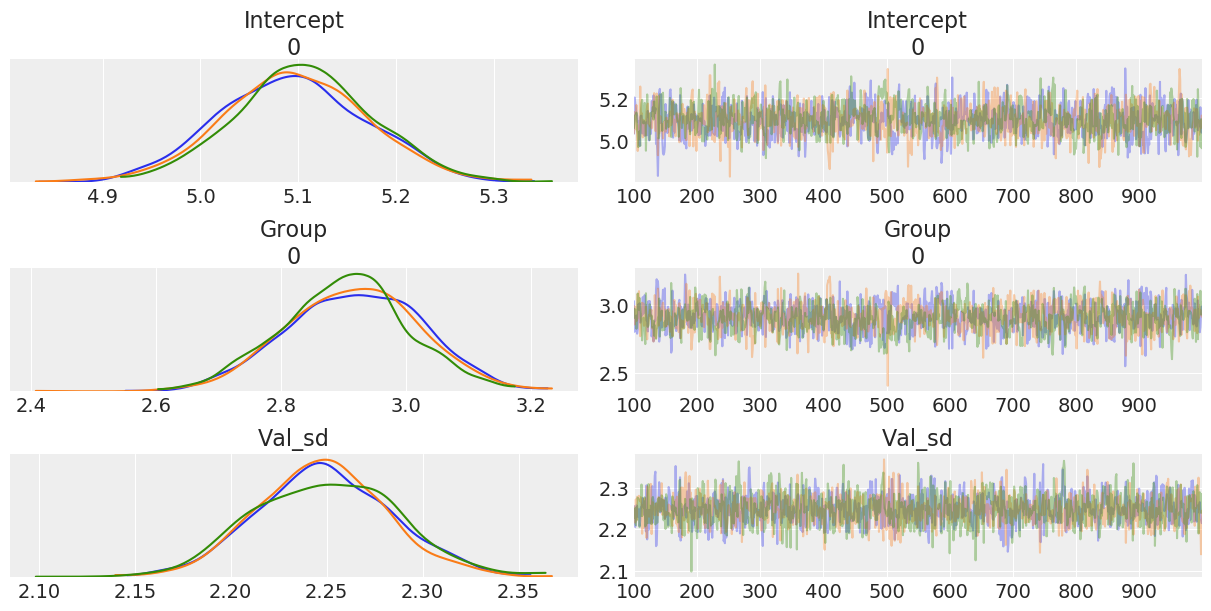

In [13]:
#Posterior plots removing first 100 samples for burn-in
res_b_sliced = res_b.posterior.sel(draw=slice(100, 1000))
az.plot_trace(res_b_sliced);

In [14]:
az.summary(res_b_sliced)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],5.099,0.072,4.970,5.237,0.002,0.001,1221.0,1221.0,1217.0,1487.0,1.01
Group[0],2.912,0.103,2.725,3.109,0.003,0.002,1345.0,1340.0,1328.0,1649.0,1.00
Val_sd,2.249,0.035,2.183,2.313,0.001,0.001,2134.0,2125.0,2143.0,1761.0,1.00


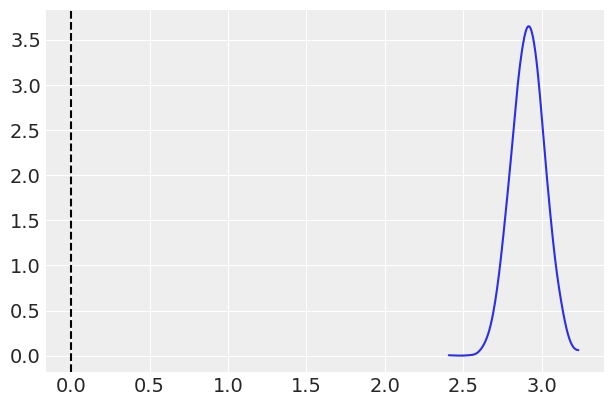

In [15]:
# Grab just the posterior of the term of interest (group)
group_posterior = res_b.posterior['Group'].values
ax = az.plot_kde(group_posterior)
ax.axvline(0, 0, 3, linestyle='--', color='k');

In [16]:
#Probabiliy that posterior is > 0
(group_posterior > 0).mean()

1.0

## Use multi-level regression data

Next we'll use a multi-level dataset included with R and statsmodels containing [the growth curve of pigs](https://www.rdocumentation.org/packages/doBy/versions/4.6-2/topics/data-dietox). Since we measure the weight of each pig multiple times, we'll estimate a model that allows random intercepts and slopes for time, for each pig.

In [17]:
# Load up data from statsmodels
import statsmodels.api as sm

data = sm.datasets.get_rdataset('dietox','geepack').data
data.describe()

,Weight,Feed,Time,Pig,Evit,Cu,Litter
count,861.000000,789.000000,861.000000,861.000000,861.000000,861.000000,861.000000
mean,60.725769,80.728645,6.480836,6238.319396,2.026713,2.015099,12.135889
std,24.978881,52.877736,3.444735,1323.845928,0.817246,0.807525,7.427252
min,15.000000,3.300003,1.000000,4601.000000,1.000000,1.000000,1.000000
25%,38.299990,32.800003,3.000000,4857.000000,1.000000,1.000000,5.000000
50%,59.199980,74.499996,6.000000,5866.000000,2.000000,2.000000,11.000000
75%,81.199950,123.000000,9.000000,8050.000000,3.000000,3.000000,20.000000
max,117.000000,224.500000,12.000000,8442.000000,3.000000,3.000000,24.000000


### Frequentist multi-level model

In [18]:
# Statsmodels produces some convergence warnings, but the results are the same as those
# produced by lme4 in R. So let's just ignore them for cleaner outputs
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    result = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"],re_formula="~Time").fit()
    print(result.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Weight    
No. Observations:  861      Method:              REML      
No. Groups:        72       Scale:               5.7891    
Min. group size:   11       Likelihood:          -2220.3890
Max. group size:   12       Converged:           No        
Mean group size:   12.0                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        15.739    0.672 23.438 0.000 14.423 17.055
Time              6.939    0.085 81.326 0.000  6.772  7.106
Group Var        30.266    4.271                           
Group x Time Cov  0.746    0.304                           
Time Var          0.483    0.046                           



### Bayesian multi-level model

In [19]:
b_model = Model(data)
results = b_model.fit('Weight ~ Time',random=['Time|Pig'],samples=1000, chains=3)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Weight_sd, Time|Pig_offset, Time|Pig_sd, 1|Pig_offset, 1|Pig_sd, Time, Intercept]
INFO:pymc3:NUTS: [Weight_sd, Time|Pig_offset, Time|Pig_sd, 1|Pig_offset, 1|Pig_sd, Time, Intercept]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:53<00:00, 84.87draws/s] 
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [20]:
b_model.backend.model

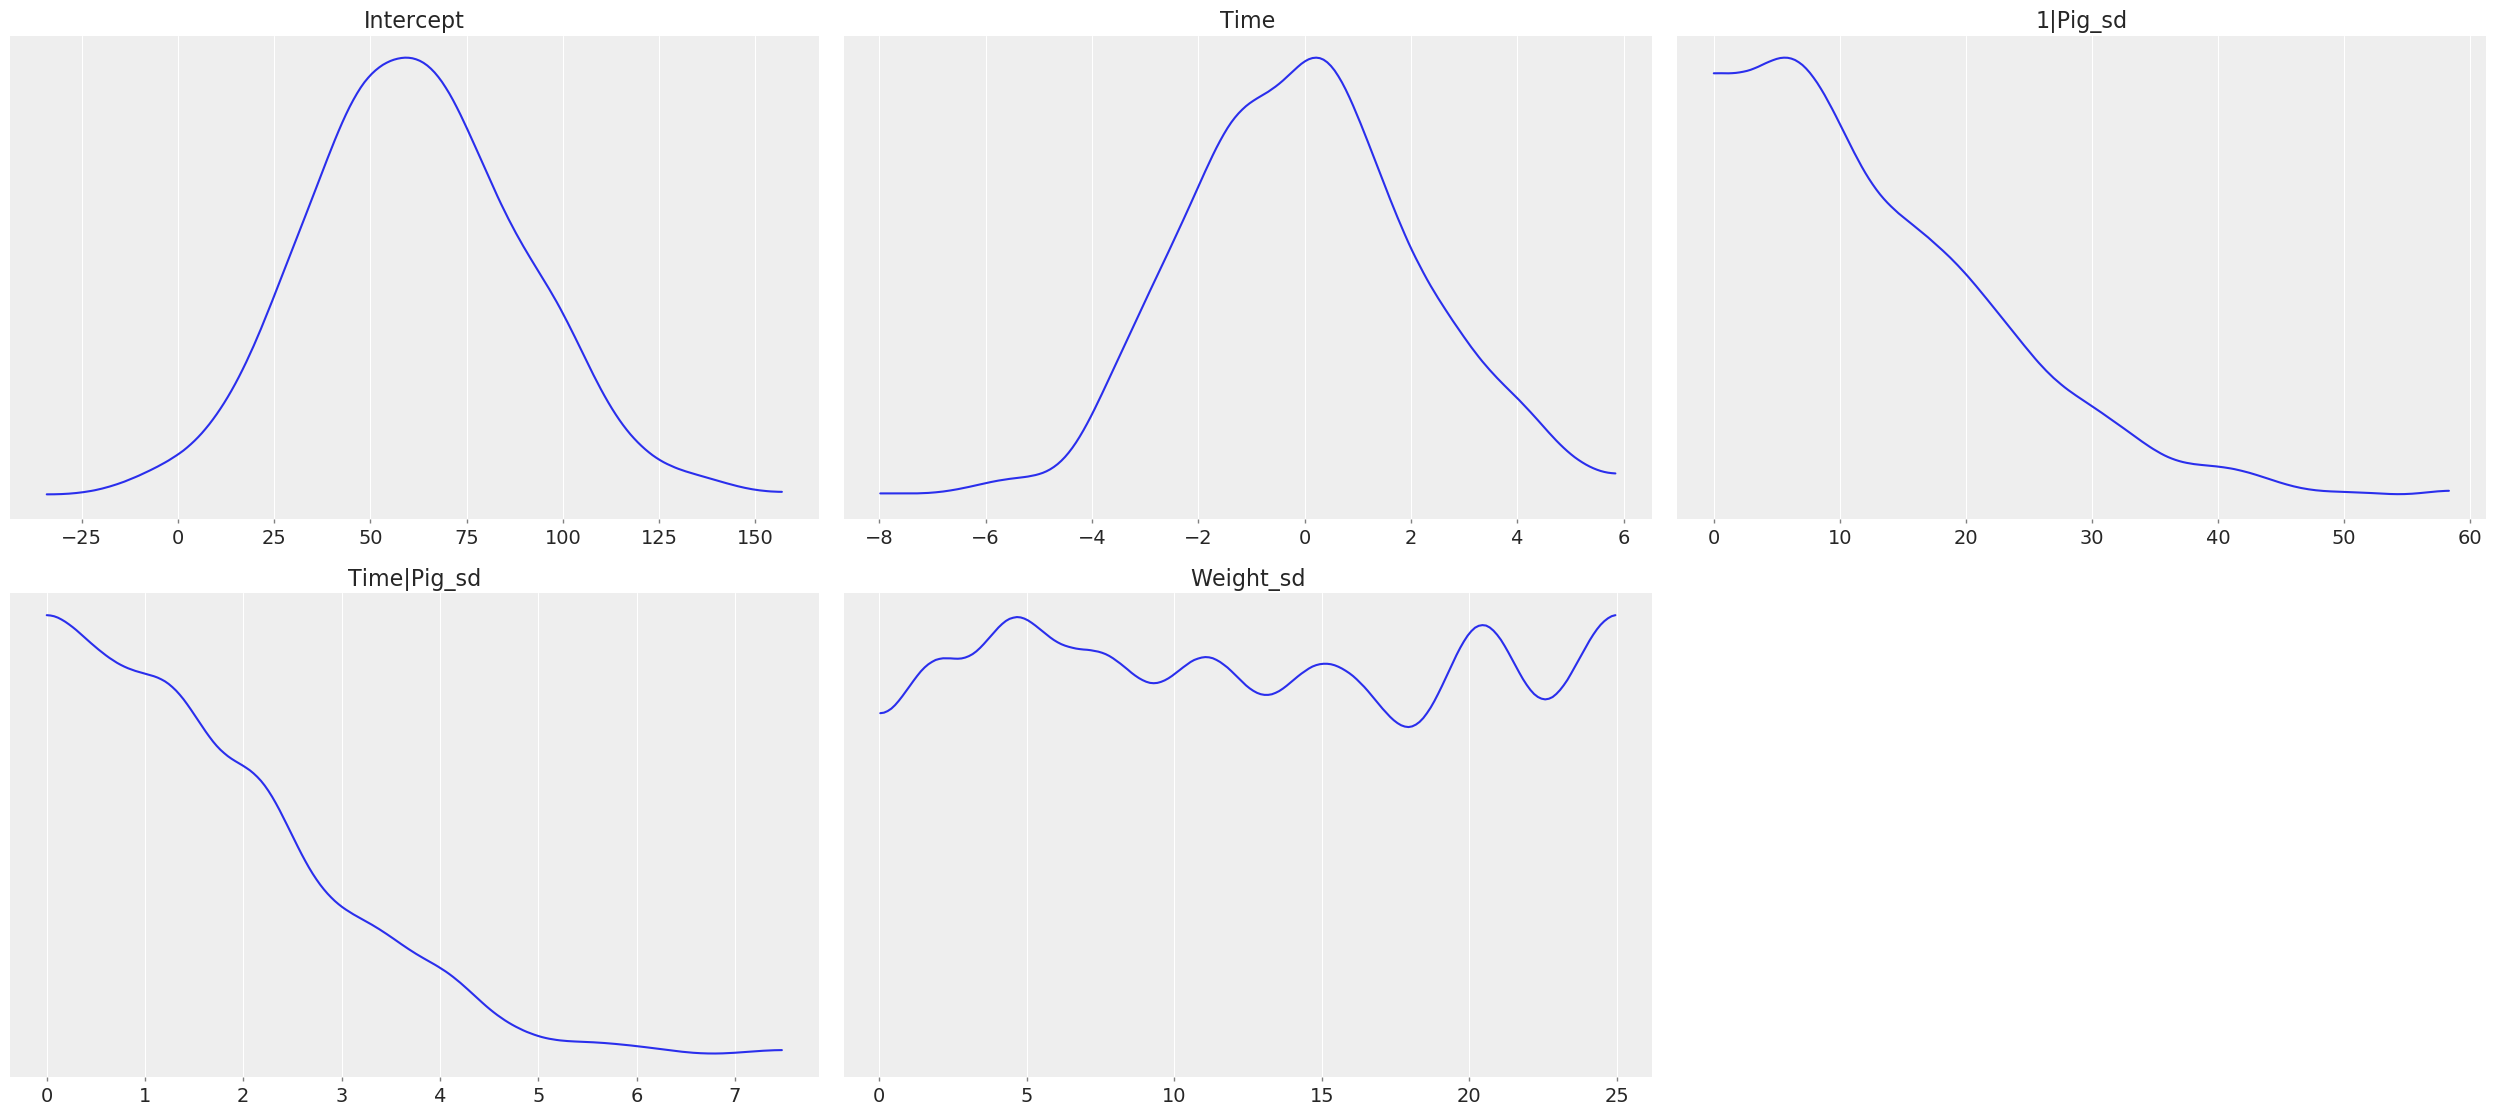

In [21]:
# Plot priors
b_model.plot();

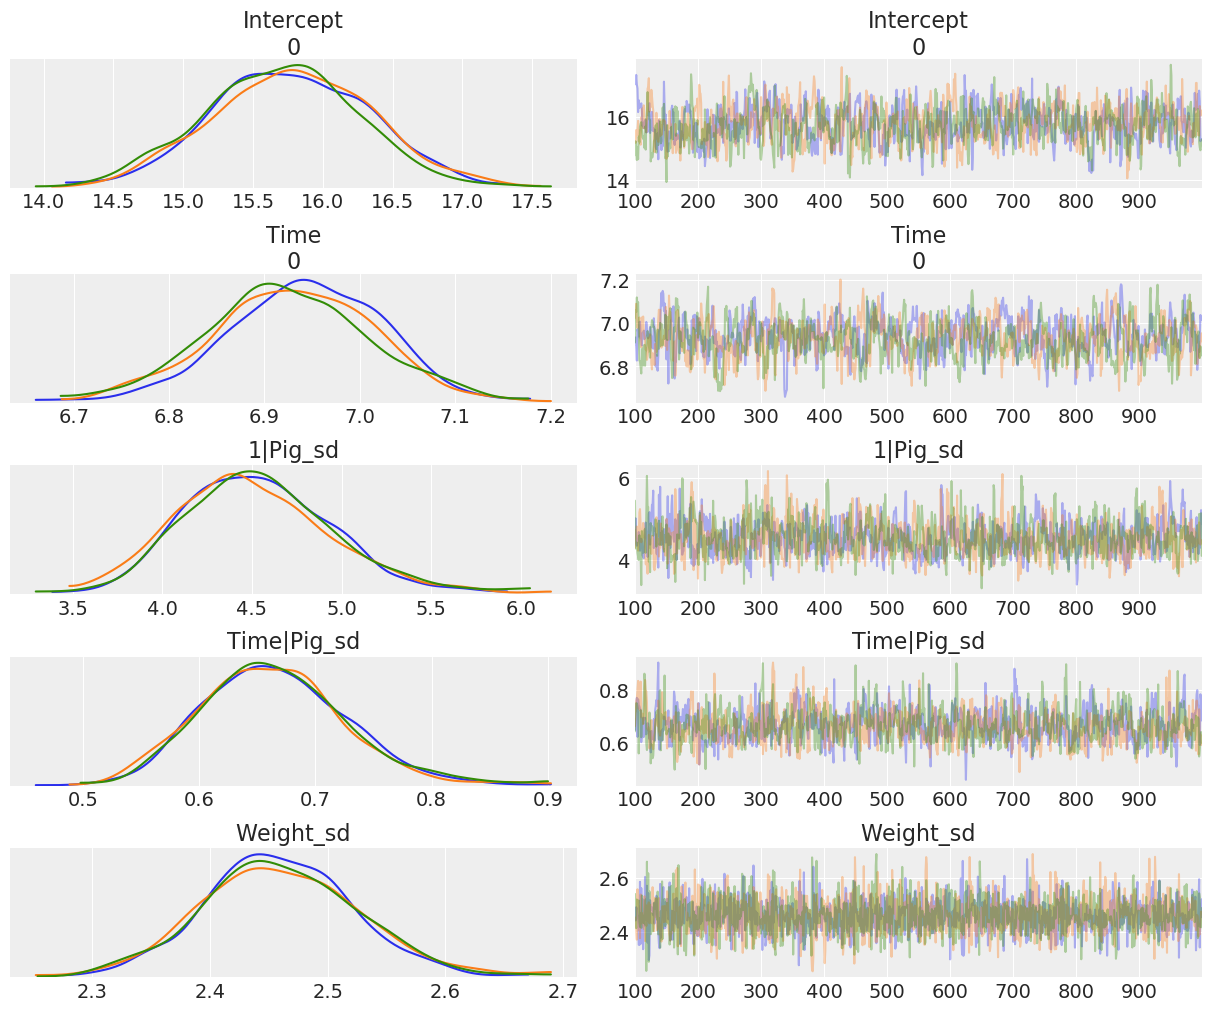

In [22]:
#Plot posteriors
results_sliced = results.posterior.sel(draw=slice(100, 1000))
az.plot_trace(results_sliced,
              var_names=['Intercept', 'Time', '1|Pig_sd', 'Time|Pig_sd', 'Weight_sd']);

In [23]:
az.summary(results_sliced, var_names=['Intercept', 'Time', '1|Pig_sd', 'Time|Pig_sd', 'Weight_sd'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],15.752,0.562,14.676,16.775,0.021,0.015,698.0,698.0,699.0,1241.0,1.01
Time[0],6.932,0.084,6.765,7.081,0.004,0.002,573.0,573.0,574.0,935.0,1.01
1|Pig_sd,4.531,0.423,3.787,5.345,0.014,0.010,896.0,871.0,927.0,1297.0,1.00
Time|Pig_sd,0.664,0.062,0.545,0.772,0.002,0.001,934.0,931.0,941.0,1338.0,1.00
Weight_sd,2.460,0.065,2.333,2.579,0.001,0.001,3266.0,3257.0,3259.0,2082.0,1.00


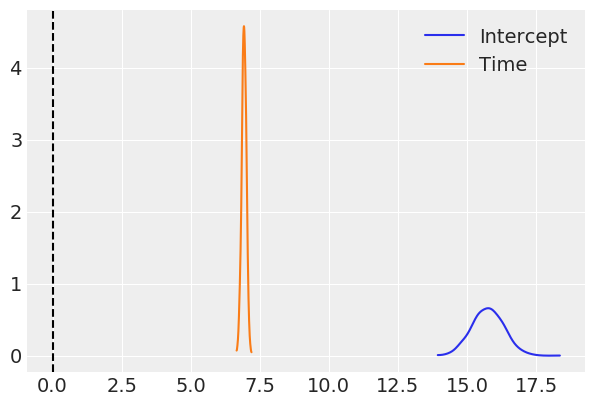

In [25]:
az.plot_kde(results.posterior['Intercept'], plot_kwargs={'color':'C0'}, label='Intercept');
az.plot_kde(results.posterior['Time'], plot_kwargs={'color':'C1'}, label='Time');
plt.axvline(0,color='k',linestyle='--')
plt.legend();

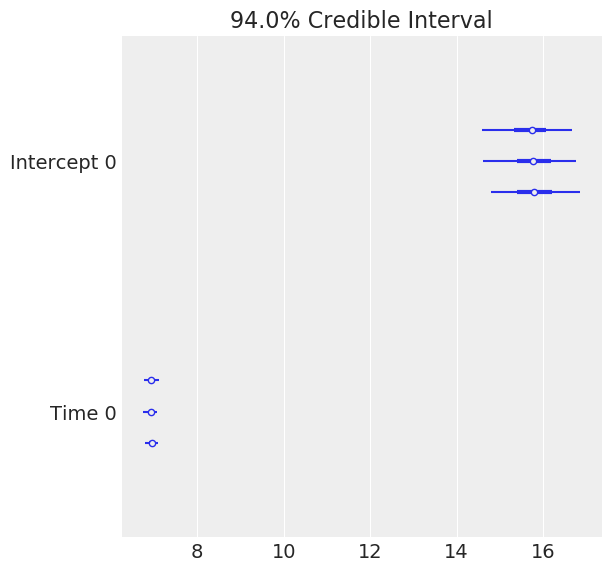

In [26]:
# Credible interval plot using pymc3
# Line is 94% credible interval calculated as higher posterior density
# Inter quartile range is thicker line
# Dot is median
az.plot_forest(results,
               var_names=list(map(str,b_model.backend.model.vars[:2])));

We can also plot the posterior overlayed with a region of practical equivalence (ROPE), i.e. range of values that were the coefficients to fall into, we might interpret them differently. 
We can see that all our posterior distributions fall outside of this range.

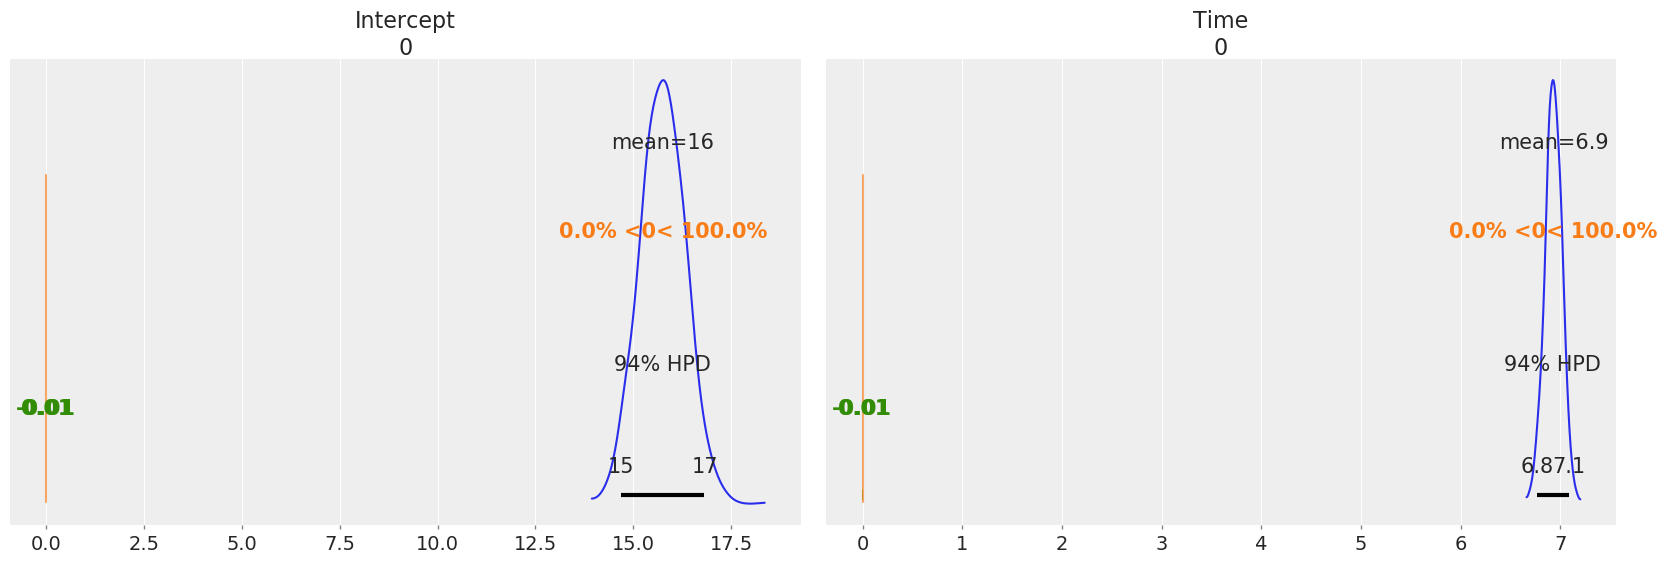

In [27]:
# Show credible interval cutoffs,
# and also overlay region of practical equivalence (arbitrary, in this case close enough to 0 do not matter)
pm.plot_posterior(results,
                  var_names=list(map(str,b_model.backend.model.vars[:2])),
                  ref_val=0,
                  rope=[-.01,.01]);